# Markowitz Model for Portfolio Optimization


The following is a workbook that will compute optimal portfolio weights uaing historic data on simulated portfolios. This is a watered down version of an on going product designed to be as simple as possible for user unfamiliar with Python or Financial Engineering.

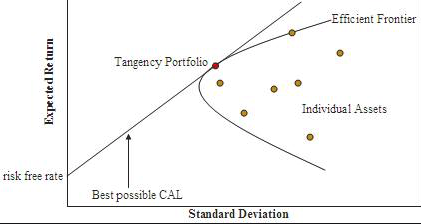

To use this there will be a few packages you are required to install. If you are on windows I would reccomend using Anaconda Prompt, MacOS and Linux users can use their terminal.

The following are the dependencies and call all be installed using the 'Pip' command:



Required Libraries:
- **pandas**: we will be storing data in dataframes to manipluate and the finally present
- **numpy**: for matrix mathematics and array functions
- **YahooFinancials**: for historic data on the assets you are filling the portfolio with
- **scipy**: using a transpose function to rearrange data
- **seaborn**: for plotting
- **matplotlib**: also for plotting


## **All of the code in this workbook has been heavily commented, so you can follow along on what is happening.**



## Boring Math
Also to those who wish to see more of the underpinning mathematics, we are looking to optimize the return on the basket based on standard deviation of returns being minimized to rate of returns. We calculate this using the variance of the portfolio returns.

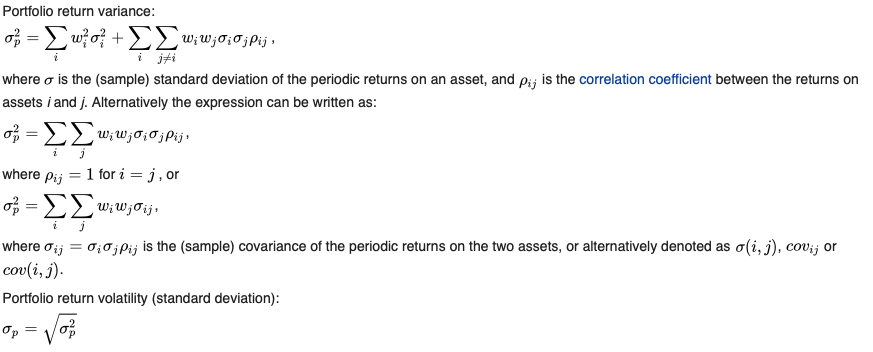

For those that have worked with regression this should be easy. 

We also will be using Sharpe Ratio to quantify risk adjusted return:
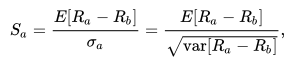

where:
- Ra is return on asset
- Rb is return on risk free assets



# User Inputs

To make this as simple as possible once all the prep has been done (installing packages from above) the user only needs to **populate line 8** with the tickers of the assets within the portfolio and **line 11 is where you input the date range**. 

**If the asset is traded on the TSX include '.TO' behind it. Example: Canopy Growth - WEED.TO**

After this click on "Cell" at the top and select "Run All"

At the bottom will be the weights for maximum sharpe

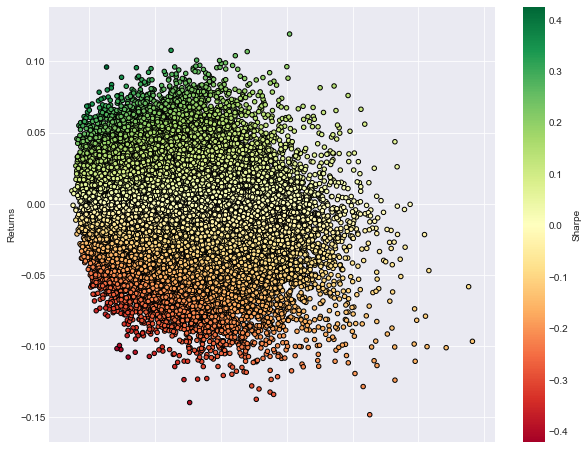

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
from yahoofinancials import YahooFinancials
import seaborn as sns
import scipy.optimize as sco

tickers = ['APHA.TO','FDN', 'PHR.TO','BTI','WEED.TO','XAR'] #Insert tickers of assets you wish to simulate

assets = YahooFinancials(tickers)
daily_prices = assets.get_historical_price_data('2018-01-01', '2020-04-22', 'daily') #Change dates as needed


df = pd.DataFrame(daily_prices[tickers[0]]['prices']) #creates a pandas dataframe of the JSON data

for name in daily_prices.keys():    #We are going to consolidate 
    tdf = pd.DataFrame(daily_prices[name]['prices'])
    df['Date'] = tdf['formatted_date']
    df[name] = tdf['adjclose']
    
not_needed = ['date','high','low', 'close', 'open', 'volume','adjclose','formatted_date']
#cleaning up dataframe removing uneeded features
for column in not_needed:
    df.drop([column], axis=1, inplace=True)

df = df.set_index('Date')

preturns = []
pvol = []
sharpe = []
assetweights = []

returnsD = df.pct_change()
returnsA = returnsD.mean()*250
covD = returnsD.cov()
covA = covD * 250

simulations = 50000
np.random.seed(101)   #All assets need to be exposed to the same numbers to simulate the market

for p in range(simulations):
    weights = np.random.random(len(tickers)) #Generage random numbers to be weights # = # of assets
    weights /= np.sum(weights)               #Make them into percentages that sum to 1
    returns = np.dot(weights, returnsA)      #Calc p returns, the product of 2 matrices is then summed 
    vol = np.sqrt(np.dot(weights.T, np.dot(covA, weights)))      #Calc volatility
    s = returns/vol                          #Sharpe Ratio calc
    sharpe.append(s)                         #adding outputs to various lists
    preturns.append(returns)
    pvol.append(vol)
    assetweights.append(weights)

#Creating a dictionary to build new dataframe
portfolio = {'Returns':preturns,
             'Volatility':pvol,
             'Sharpe': sharpe}

for counter, ticker in enumerate(tickers):
    portfolio[ticker + ' Weight'] = [Weight[counter] for Weight in assetweights]

finaldf = pd.DataFrame(portfolio)

ColumnOrder = ['Returns', 'Volatility', 'Sharpe'] + [ticker + ' Weight' for ticker in tickers]

finaldf = finaldf[ColumnOrder]

min_volatility = finaldf['Volatility'].min()
max_sharpe = finaldf['Sharpe'].max()

sharpe_portfolio = finaldf.loc[finaldf['Sharpe'] == max_sharpe]
min_variance_port = finaldf.loc[finaldf['Volatility'] == min_volatility]

plt.style.use('seaborn-dark')
finaldf.plot.scatter(x='Volatility', y='Returns', c='Sharpe', cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

In [11]:
print('Minimum Variance Portfolio: ')
print(min_variance_port.T)
print('\nSharpe Portfolio: ')
print(sharpe_portfolio.T)

Minimum Variance Portfolio: 
                   19813
Returns         0.009082
Volatility      0.173294
Sharpe          0.052409
APHA.TO Weight  0.012083
FDN Weight      0.141833
PHR.TO Weight   0.612737
BTI Weight      0.158004
WEED.TO Weight  0.015565
XAR Weight      0.059779

Sharpe Portfolio: 
                   35772
Returns         0.096081
Volatility      0.225993
Sharpe          0.425151
APHA.TO Weight  0.005537
FDN Weight      0.640829
PHR.TO Weight   0.221013
BTI Weight      0.019449
WEED.TO Weight  0.102115
XAR Weight      0.011057


# What does it mean?

Above here is a breakdown of the weights required to maximize sharpe ratio or to minimize variance. If you are seeking the best risk adjusted return you will want to use the values under the Sharpe Portfolio. If you are looking to minimize risk then use the values in Minimum Variance Portfolio. 